In [1]:
# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
  

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !unzip  "/content/drive/MyDrive/Colab Notebooks/QuestionAnsweringDataset/images_background.zip"
# !unzip "/content/drive/MyDrive/Colab Notebooks/QuestionAnsweringDataset/images_evaluation.zip"

# **All Files Path**

In [ ]:
train_folder = "/content/images_background"
val_folder = '/content/images_evaluation'
save_path = '/content/drive/MyDrive/Colab Notebooks/QuestionAnsweringDataset/data'
model_checkpoints='/content/drive/MyDrive/Colab Notebooks/QuestionAnsweringDataset/data/checkpoints'

## **Importing all Packages**

In [18]:
import sys
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D,Input,Concatenate,ZeroPadding2D,Activation,MaxPooling2D,Concatenate,\
Lambda, Flatten, Dense
from tensorflow.keras.models import Model
#from keras.layers.pooling import MaxPooling2D
#from keras.layers.merge import Concatenate
#from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer,BatchNormalization
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng
#%pip --quiet install pillow
#from scipy.misc import imread
#from pillow import imread
from PIL import Image

## **Laoding Images**

In [5]:
def load_images(path,n = 0):
    #structure of the data is like -- language_type --> letters--> 20 handwritten images of each letter size of (105,105)
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        # every letter/categor
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                #im = Image.open(image_path)
                #a = np.asarray(im)
                #image= Image.fromarray(a)
                image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
                category_images.append(image)
                y.append(curr_y)
            try:
                #print(category_images,np.stack(category_images).shape)
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    #return data in this format X=(total_letters,20-->images ,105,105) y=(total_letters*20) as we will consider each letter as different class
    return X,y,lang_dict

In [ ]:
X,y,c=load_images(train_folder)

loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Grantha
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Greek
loading alphabet: Japanese_(katakana)
loading alphabet: Bengali
loading alphabet: Cyrillic
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Tagalog
loading alphabet: Latin
loading alphabet: Sanskrit
loading alphabet: Armenian
loading alphabet: Korean
loading alphabet: Hebrew
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Japanese_(hiragana)
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: N_Ko
loading alphabet: Balinese
loading alphabet: Tifinagh
loading alphabet: Arcadian
loading alphabet: Gujarati
loading alphabet: Futurama
loading alphabet: Burmese_(Myanmar)
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Early_Aramaic
loading alphabet: Braille


In [ ]:
X.shape,y.shape

((964, 20, 105, 105), (19280, 1))

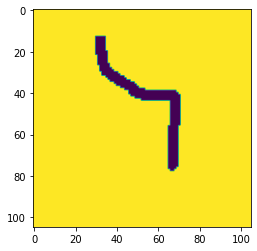

[0]


In [ ]:
plt.imshow(X[0][0]) #sample
plt.show()

print(y[0]) #we assign each letter one class so we have total 964 letters therefore we have classes from 0 to 963

In [ ]:
c

{'Alphabet_of_the_Magi': [98, 117],
 'Anglo-Saxon_Futhorc': [578, 606],
 'Arcadian': [719, 744],
 'Armenian': [407, 447],
 'Asomtavruli_(Georgian)': [876, 915],
 'Balinese': [640, 663],
 'Bengali': [203, 248],
 'Blackfoot_(Canadian_Aboriginal_Syllabics)': [0, 13],
 'Braille': [938, 963],
 'Burmese_(Myanmar)': [819, 852],
 'Cyrillic': [249, 281],
 'Early_Aramaic': [916, 937],
 'Futurama': [793, 818],
 'Grantha': [55, 97],
 'Greek': [132, 155],
 'Gujarati': [745, 792],
 'Hebrew': [488, 509],
 'Inuktitut_(Canadian_Aboriginal_Syllabics)': [510, 525],
 'Japanese_(hiragana)': [526, 577],
 'Japanese_(katakana)': [156, 202],
 'Korean': [448, 487],
 'Latin': [339, 364],
 'Malay_(Jawi_-_Arabic)': [282, 321],
 'Mkhedruli_(Georgian)': [14, 54],
 'N_Ko': [607, 639],
 'Ojibwe_(Canadian_Aboriginal_Syllabics)': [118, 131],
 'Sanskrit': [365, 406],
 'Syriac_(Estrangelo)': [853, 875],
 'Tagalog': [322, 338],
 'Tifinagh': [664, 718]}

In [ ]:
with open(os.path.join(save_path,"train.pickle"), "wb") as f: #saving our data tensors into pickle file 
    pickle.dump((X,c),f)

In [ ]:
Xval,yval,cval=load_images(val_folder)

loading alphabet: Old_Church_Slavonic_(Cyrillic)
loading alphabet: Avesta
loading alphabet: Manipuri
loading alphabet: Mongolian
loading alphabet: Aurek-Besh
loading alphabet: Atlantean
loading alphabet: Malayalam
loading alphabet: Tibetan
loading alphabet: Gurmukhi
loading alphabet: Kannada
loading alphabet: ULOG
loading alphabet: Atemayar_Qelisayer
loading alphabet: Tengwar
loading alphabet: Oriya
loading alphabet: Syriac_(Serto)
loading alphabet: Ge_ez
loading alphabet: Keble
loading alphabet: Sylheti
loading alphabet: Angelic
loading alphabet: Glagolitic


In [ ]:
with open(os.path.join(save_path,"val.pickle"), "wb") as f:
    pickle.dump((Xval,cval),f)

## **Creating Data For Training**

In [12]:
def get_batch(batch_size,Xtrain,Xval,train_classes,val_classes,s="train"):
    """Create batch of n pairs, half same class, half different class"""
    #print('train',Xtrain.shape,'val',Xval.shape)
    #shape of Xtrain (964, 20, 105, 105) and shape of Xval (659, 20, 105, 105)
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape
    #print('n classes--',n_classes,'--n_examples--',n_examples)
    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False) #depends on the batch if batch_size is 2 then categories will be [x1,x2]
    #if batch_size 4 then categories [x1,x2,x3,x4] where xi lies between 0-n_classes
    #print('categories',categories)
    # initialize 2 empty arrays for the input image batch , here we are making pair of images for training purpose 
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)] #list something like this = [[batch_size,h,w,1],[batch_size,h,w,1]]

    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)#X[class_id,out_of_20_images] 
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  #for same class sample 
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
    
    return pairs, targets

In [7]:
# pairs=[np.zeros((4, 105, 105,1)) for i in range(1)]
# categories = rng.choice(10,size=(4,),replace=False)

In [ ]:
#categories

In [27]:
with open(os.path.join(r"E:\DATASETS\Few_shots_learning_dataset", "train.pickle"), "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(train_classes.keys()))


Training alphabets: 

['Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Mkhedruli_(Georgian)', 'Grantha', 'Alphabet_of_the_Magi', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Greek', 'Japanese_(katakana)', 'Bengali', 'Cyrillic', 'Malay_(Jawi_-_Arabic)', 'Tagalog', 'Latin', 'Sanskrit', 'Armenian', 'Korean', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Anglo-Saxon_Futhorc', 'N_Ko', 'Balinese', 'Tifinagh', 'Arcadian', 'Gujarati', 'Futurama', 'Burmese_(Myanmar)', 'Syriac_(Estrangelo)', 'Asomtavruli_(Georgian)', 'Early_Aramaic', 'Braille']


In [28]:
with open(os.path.join(r"E:\DATASETS\Few_shots_learning_dataset", "val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)

print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Validation alphabets:

['Old_Church_Slavonic_(Cyrillic)', 'Avesta', 'Manipuri', 'Mongolian', 'Aurek-Besh', 'Atlantean', 'Malayalam', 'Tibetan', 'Gurmukhi', 'Kannada', 'ULOG', 'Atemayar_Qelisayer', 'Tengwar', 'Oriya', 'Syriac_(Serto)', 'Ge_ez', 'Keble', 'Sylheti', 'Angelic', 'Glagolitic']


## **Creating generator here so that we can load our data for training in more efficient way**

In [13]:
#creating generator here so that we can load our data for training in more efficient way 
def generate(batch_size,Xtrain,Xval,train_classes,val_classes, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,Xtrain,Xval,train_classes,val_classes)
        yield (pairs, targets)

In [ ]:
dataset=generate(16,Xtrain,Xval,train_classes,val_classes)

In [ ]:
pairs,targets=next(dataset)
print(np.array(pairs).shape,np.array(targets).shape)

(2, 16, 105, 105, 1) (16,)


In [11]:
def initialize_weights(shape, dtype=None):
    """
      The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
      suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)


## **Creating Model**

In [19]:
#creating model (siamese network)
def siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])#here we are sending input like [output_from_encode_l , output_from_encode_r]
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [21]:
model = siamese_model((105, 105, 1))
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 4096)         38947648    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_3[0][0]    

In [22]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

In [23]:
#retraining 
model.load_weights(os.path.join(r"E:\DATASETS\Few_shots_learning_dataset","weights.19800.h5"))

## **Data Creation for One shot Training**

In [53]:
def make_oneshot_task(N,Xtrain,Xval,train_classes,val_classes,s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]#as we have created dict in starting where we added images count in this manner Gujarati': [745, 792],
        if N > high - low:#number of samples we can take should be less than total images of that class
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)

    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)  
    #print('categories is',categories)          
    true_category = categories[0]#taking first image as true
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    #print(ex1,ex2,'exx')
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1) #we have to make pair of original with the images in the support set
    #thats why we multiple this image by N to
    #print(np.array(test_image).shape,'test image size ')
    support_set = X[categories,indices,:,:]
    #print(support_set.shape)
    support_set[0,:,:] = X[true_category,ex2]#setting first image in the support set same as of original class  image 
    #print(support_set.shape)
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1#setting first image target=1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

## **Testing our model using Few shot prediction**

In [140]:
def test_oneshot(model,Xtrain,Xval,train_classes,val_classes,N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,Xtrain,Xval,train_classes,val_classes,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct , probs

In [ ]:
# Hyper parameters
evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 20000 # No. of training iterations
N_way = 20 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

## **Training**

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(2201, n_iter+1):
    (inputs,targets) = get_batch(batch_size,Xtrain,Xval,train_classes,val_classes)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc , _ = test_oneshot(model,Xtrain,Xval,train_classes,val_classes, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_checkpoints, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            #model.save_weights(os.path.join(model_checkpoints, 'weights.{}.h5'.format(i)))
            best = val_acc

Starting training process!
-------------------------------------

 ------------- 

Time for 2400 iterations: 1.10499453941981 mins
Train Loss: 0.3082767724990845
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 70.4% 20 way one-shot learning accuracy 

Current best: 70.4, previous best: -1

 ------------- 

Time for 2600 iterations: 2.1116382916768393 mins
Train Loss: 0.344495952129364
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.4% 20 way one-shot learning accuracy 

Current best: 72.4, previous best: 70.4

 ------------- 

Time for 2800 iterations: 3.086186742782593 mins
Train Loss: 0.3863230049610138
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 69.6% 20 way one-shot learning accuracy 


 ------------- 

Time for 3000 iterations: 4.07079640229543 mins
Train Loss: 0.27617213129997253
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average

## **Testing** 

In [172]:
pairs,targets=make_oneshot_task(5,Xtrain,Xval,train_classes,val_classes) #5 way one shot testing and we are taking these images 
#from the data on which our model is  not trained and creating 5 way single shot support set
print(np.array(pairs).shape) 
print(targets)
print(np.argmax(targets))

(2, 5, 105, 105, 1)
[0. 1. 0. 0. 0.]
1


In [173]:
#val_acc , probs = test_oneshot(model,Xtrain,Xval,train_classes,val_classes, 5, 1, verbose=True)
probs = model.predict(pairs)

In [174]:
np.argmax(probs)

1

Actual Similar images index 3 Predicted similar images index 3


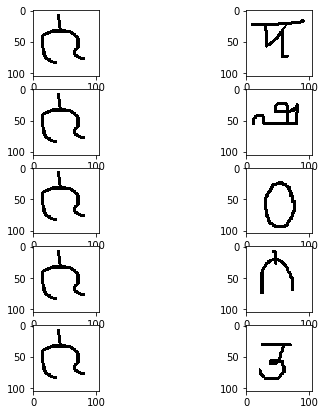

Actual Similar images index 0 Predicted similar images index 0


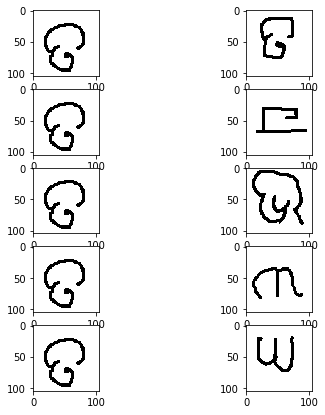

Actual Similar images index 3 Predicted similar images index 3


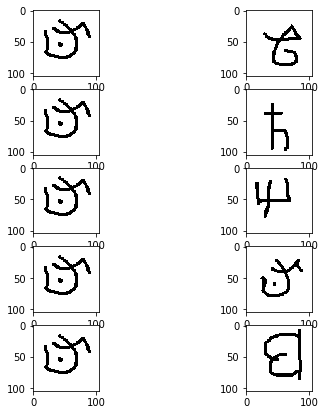

Actual Similar images index 4 Predicted similar images index 4


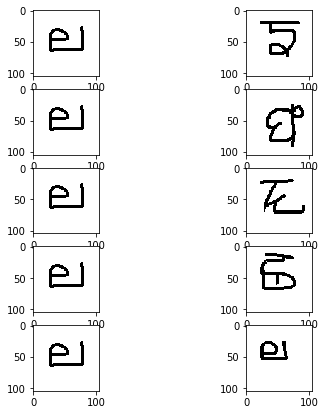

Actual Similar images index 1 Predicted similar images index 1


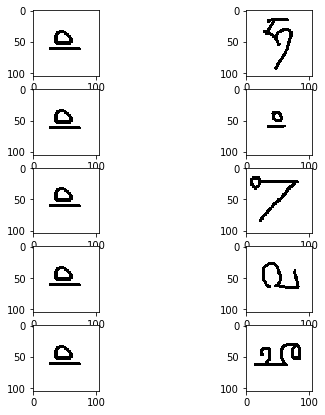

In [184]:
#plot 1:
def plotting(pairs):
    fig,a =  plt.subplots(5,2,figsize=(7,7))
    for i in range(0,5):
        a[i][0].imshow(pairs[0][i].reshape(105,105),cmap='gray')
        a[i][1].imshow(pairs[1][i].reshape(105,105),cmap='gray')
        
#fig=plt.figure(figsize=(15,15))
for i in range(0,5):
    pairs,targets=make_oneshot_task(5,Xtrain,Xval,train_classes,val_classes)
    probs = model.predict(pairs)
    pred_max,act_max=np.argmax(probs),np.argmax(targets)
    print("Actual Similar images index {}".format(act_max),'Predicted similar images index {}'.format(pred_max))
    plotting(pairs)
    plt.show()

